In [1]:
import merg_rates3 as merg_rates
import numpy as np
import pandas as pd
import time
import gc
import operator

from progressbar import ProgressBar

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib import rcParams
%matplotlib inline

rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['font.family'] = 'serif' 
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.grid']=True
rcParams['axes.titlesize']=24
rcParams['axes.labelsize']=20
rcParams['axes.titlepad']=15
rcParams['legend.frameon'] = True
rcParams['legend.facecolor']='white'
rcParams['legend.fontsize']=18

In [3]:
with open('/home/users/staudt/projects/mergers/data/arw_quench.dat',
          'r') as f:
    df = pd.DataFrame((l.rstrip().split() for l in f),dtype=float)
ms=np.array(df[0])

with open('/home/users/staudt/projects/mergers/data/arw_lidromar_mrgfrac.csv',
          'r') as f:
    arw_lidromar = pd.read_csv(f)

In [4]:
total_st=time.time()

In [5]:
htpm=merg_rates.HalTreepmClass()

# in merg_rates3.HalTreepm():
  read /data1/arwetzel/lcdm250/snapshot.txt
  read  5177765 subhalo from subhalo_tree_00.dat
  read  5407196 subhalo from subhalo_tree_01.dat
  read  5485481 subhalo from subhalo_tree_02.dat
  read  5517336 subhalo from subhalo_tree_03.dat
  read  5548084 subhalo from subhalo_tree_04.dat
  read  5583078 subhalo from subhalo_tree_05.dat
  read  5615345 subhalo from subhalo_tree_06.dat
  read  5650410 subhalo from subhalo_tree_07.dat
  read  5682696 subhalo from subhalo_tree_08.dat
  read  5715688 subhalo from subhalo_tree_09.dat
  read  5748795 subhalo from subhalo_tree_10.dat
  read  5779167 subhalo from subhalo_tree_11.dat
  read  5805949 subhalo from subhalo_tree_12.dat
  read  5824060 subhalo from subhalo_tree_13.dat
  read  5837797 subhalo from subhalo_tree_14.dat
  read  5841491 subhalo from subhalo_tree_15.dat
  read  5836226 subhalo from subhalo_tree_16.dat
  read  5823060 subhalo from subhalo_tree_17.dat
  read  5795900 subhalo from subhalo_tree_18

In [6]:
def clean_mem():
    print("Uncollectable garbage:", gc.garbage)
    n=gc.collect()
    print("Number of unreachable objects collected by GC:", n)
    print("Uncollectable garbage:", gc.garbage)
    return None

def quench_frac_f(gtpm,ziend=34,cutoff=-np.inf):    
    
    #updating methods
    import importlib
    importlib.reload(merg_rates)   
    quench_frac_ft=merg_rates.GalTreepmClass.quench_frac_ft
    hgram_dat_ft=merg_rates.GalTreepmClass.hgram_dat_ft   
    #gtpm.quench_frac_ft=quench_frac_ft.__get__(gtpm,merg_rates.GalTreepmClass)
    #gtpm.hgram_dat_ft=hgram_dat_ft.__get__(gtpm,merg_rates.GalTreepmClass)    
    import types
    funcType=types.MethodType
    gtpm.hgram_dat_ft=funcType(hgram_dat_ft,gtpm)
    gtpm.quench_frac_ft=funcType(quench_frac_ft,gtpm)
    
    st=time.time()
    f3=gtpm.quench_frac_ft(min_mu=np.log10(1./3.),zibeg=1,ziend=ziend,
                           M0s=ms,cutoff=cutoff)
    f10=gtpm.quench_frac_ft(min_mu=np.log10(1./10.),zibeg=1,ziend=ziend,
                            M0s=ms,cutoff=cutoff)
    print('{0:0.1f} min runtime'.format((time.time()-st)/60.))
    return f3[0],f3[1],f10[1]

In [31]:
def mk_quench_plt(fs_mar,fs_per,fs_san,fs_muz,fs_fon,scat,zi,
                  cutoff=-np.inf,cutdir='\geq'):
    z=htpm.subcat[zi].snap['z']
    def get_shade(dat,axi):
        fs=np.array([dat[i][axi] for i in range(dat.shape[0])])
        lo=fs.min(axis=0)
        hi=fs.max(axis=0)
        return np.array([lo,hi])

    dat=np.array([fs_mar,fs_per,fs_san,
         fs_muz,fs_fon])
    shade3=get_shade(dat,1)
    shade10=get_shade(dat,2)
    nams=['Marchesini',
          'P$\mathrm{\\acute{e}}$rez-Gonz$\mathrm{\\acute{a}}$lez',
          'Santini','Muzzin','Fontana']

    fig,axs=plt.subplots(3,2,figsize=(11,9),sharex=True,sharey=True)
    axs=axs.ravel()
    fig.subplots_adjust(wspace=0.,hspace=0.)

    cols = mpl.cm.rainbow(np.linspace(0, 1, 5))

    for axi,(fs,nam) in enumerate(zip(dat,nams)):
        axs[axi].fill_between(ms,shade3[1],shade3[0],alpha=0.1,color=cols[0])
        axs[axi].fill_between(ms,shade10[1],shade10[0],alpha=0.1,color=cols[1])

        axs[axi].errorbar(ms,df[1],yerr=df[2],fmt='o',color='r',
                    elinewidth=0.9,capsize=3,ecolor='k',label='SDSS quenched centrals')
        #axs[axi].plot(ms,df[3],'--',label='Wetzel, $\mu=1/10$',color=cols[3])
        #axs[axi].plot(ms,df[5],'--',label='Wetzel, $\mu=1/3$',color=cols[4])
        
        axs[axi].plot(np.log10(arw_lidromar['M_{R>0.33,z<=2.1}']),arw_lidromar['f_{R>0.33,z<=2.1}'],
                      '--',label='Wetzel (Li-Drory-March), $\mu=1/3$, $z\leq2.1$',color=cols[4])
        axs[axi].plot(np.log10(arw_lidromar['M_{R>0.1,z<=2.1}']),arw_lidromar['f_{R>0.1,z<=2.1}'],
                      '--',label='Wetzel (Li-Drory-March), $\mu=1/10$, $z\leq2.1$',color=cols[3])

        axs[axi].plot(fs[0],fs[2],'-',label='$\mu=1/10$, $z\leq{0:0.1f}$'.format(z),
                      color=cols[1],lw=3)
        axs[axi].plot(fs[0],fs[1],'-',label='$\mu=1/3$, $z\leq{0:0.1f}$'.format(z),
                      color=cols[0],lw=3)

        axs[axi].text(0.05,0.88,nam,fontsize=19,horizontalalignment='left',
                      va='center',transform=axs[axi].transAxes,
                      bbox=dict(facecolor='white',alpha=0.7,edgecolor='none'))

    axs[0].set_ylim(0,1)
    axs[0].legend(bbox_to_anchor=(0.5,0.01),
                  bbox_transform=fig.transFigure,
                  loc="upper center",ncol=2,fontsize=17)

    for axi in [2]:
        axs[axi].set_ylabel('$f_\mathrm{gal}(\,N_\mathrm{merg}(>\mu)\geq1\,)$')
    for axi in [4,5]:
        axs[axi].set_xlabel('log $M_0/$M$_\odot$')
        plt.setp(axs[axi].xaxis.get_majorticklabels(),rotation=45)

    if cutoff == -np.inf or cutoff is None:
        plt.suptitle('$\sigma={0:0.2f}$ dex'.format(scat),fontsize=25,y=0.92)
    else:
        plt.suptitle('$\sigma={0:0.2f}$ dex, $M_z/M_0{2}{1:0.1f}$'.format(scat,
                                                                           10.**cutoff,
                                                                           cutdir),
                     fontsize=25,y=0.94)
    plt.show()
    
    return None

In [8]:
def calc_fs_and_plot(tpms,scat,ziend,cutoff,cutdir):

    fs_mar=quench_frac_f(tpms[0],ziend=ziend,cutoff=cutoff)
    fs_per=quench_frac_f(tpms[1],ziend=ziend,cutoff=cutoff)
    fs_san=quench_frac_f(tpms[2],ziend=ziend,cutoff=cutoff)
    fs_muz=quench_frac_f(tpms[3],ziend=ziend,cutoff=cutoff)
    fs_fon=quench_frac_f(tpms[4],ziend=ziend,cutoff=cutoff)

    %matplotlib inline
    mk_quench_plt(fs_mar, fs_per, fs_san, fs_muz, fs_fon,
                  scat, zi=ziend, cutoff=cutoff, cutdir=cutdir)
    return fs_mar, fs_per, fs_san, fs_muz, fs_fon

In [9]:
scat=0.
mmin=3.

st=time.time()

mar_tpm=merg_rates.GalTreepmClass(htpm,
        source=merg_rates.bld_smf_compo('marchesini'),scat=scat,
        mmin=mmin)
per_tpm=merg_rates.GalTreepmClass(htpm,
        source=merg_rates.bld_smf_compo('perez'),scat=scat,
        mmin=mmin)
san_tpm=merg_rates.GalTreepmClass(htpm,
        source=merg_rates.bld_smf_compo('santini'),scat=scat,
        mmin=mmin)
muz_tpm=merg_rates.GalTreepmClass(htpm,
        source=merg_rates.bld_smf_compo('muzzin-sameslope'),scat=scat,
        mmin=mmin)
fon_tpm=merg_rates.GalTreepmClass(htpm,
        source=merg_rates.bld_smf_compo('fontana'),scat=scat,
        mmin=mmin)

tpms_noscat=[mar_tpm, per_tpm, san_tpm,
             muz_tpm, fon_tpm]
for gtpm in tpms_noscat: 
    htpm.mp_tree(gal_tpm=gtpm)
    htpm.merg_tree(gal_tpm=gtpm)

print('{0:0.1f} min runtime'.format((time.time()-st)/60.))

running SHAM


100% |########################################################################|


running SHAM


100% |########################################################################|


running SHAM


100% |########################################################################|


running SHAM


100% |########################################################################|


running SHAM


100% |########################################################################|


building main progenitor tree:


100% |########################################################################|


building merger tree


building main progenitor tree:


100% |########################################################################|


building merger tree


building main progenitor tree:


100% |########################################################################|


building merger tree


building main progenitor tree:


100% |########################################################################|


building merger tree


building main progenitor tree:


100% |########################################################################|


building merger tree
18.3 min runtime


running quench data
running quench data
0.7 min runtime
running quench data
running quench data
1.2 min runtime
running quench data
running quench data
1.0 min runtime
running quench data
running quench data
0.8 min runtime
running quench data
running quench data
0.9 min runtime


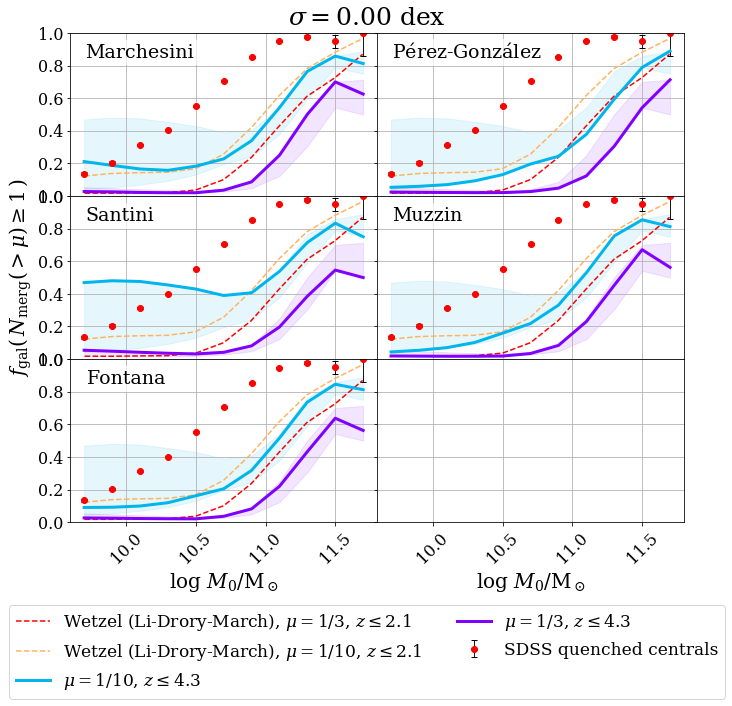

running quench data
running quench data
0.6 min runtime
running quench data
running quench data
0.9 min runtime
running quench data
running quench data
0.7 min runtime
running quench data
running quench data
0.7 min runtime
running quench data
running quench data
0.7 min runtime


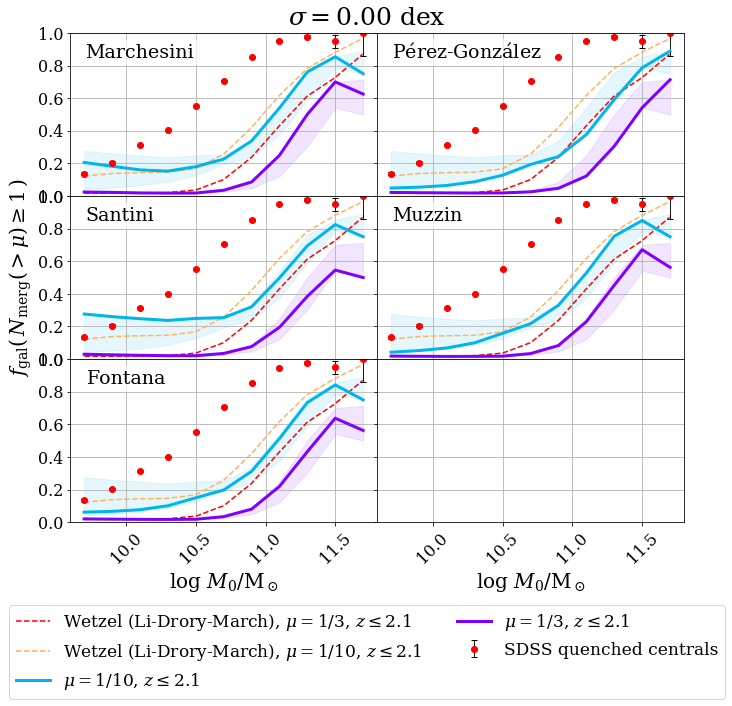

running quench data
running quench data
0.4 min runtime
running quench data
running quench data
0.5 min runtime
running quench data
running quench data
0.4 min runtime
running quench data
running quench data
0.4 min runtime
running quench data
running quench data
0.4 min runtime


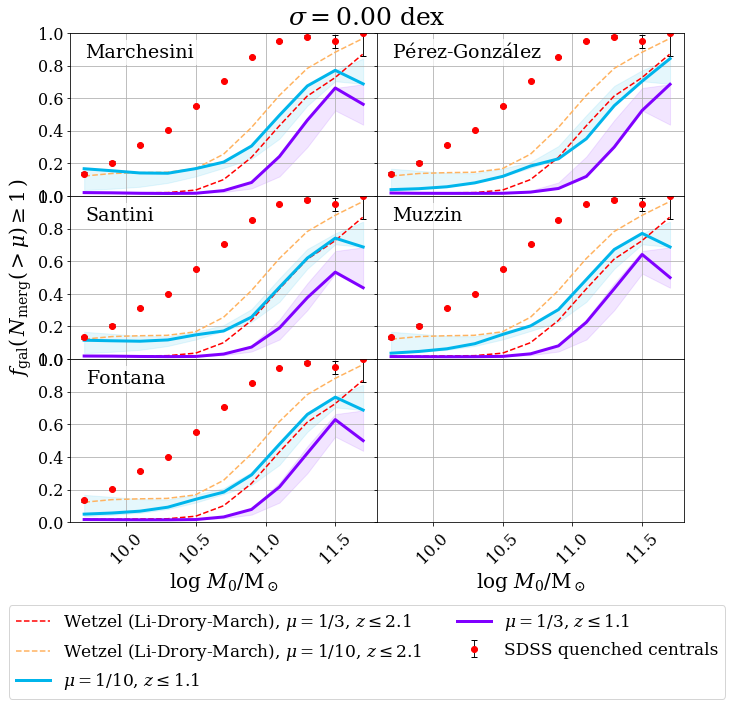

In [10]:
_ = calc_fs_and_plot(tpms_noscat, scat=scat,
                 ziend=34,cutoff=-np.inf,cutdir=None)
_ = calc_fs_and_plot(tpms_noscat, scat=scat,
                 ziend=23,cutoff=-np.inf,cutdir=None)
_ = calc_fs_and_plot(tpms_noscat, scat=scat,
                 ziend=15,cutoff=-np.inf,cutdir=None)

# Looking for the discrepancy

In [11]:
M0test=9.7
min_mu_test=np.log10(1./10.)
mu_rng_test=[min_mu_test,0.]
Mwid_test=0.1
hgram_dat_san=san_tpm.hgram_dat_ft(mu_rng_test, M0test, Mwid=Mwid_test, indices=True)
hgram_dat_mar=mar_tpm.hgram_dat_ft(mu_rng_test, M0test, Mwid=Mwid_test, indices=True)
hgram_dat_per=per_tpm.hgram_dat_ft(mu_rng_test, M0test, Mwid=Mwid_test, indices=True)

In [12]:
def inrng_f(tpm,M0):
    cat=tpm.galcat
    mtype=tpm.gmtype
    hi0s=np.arange(len(cat[0][mtype]))
    M0s=cat[0][mtype]
    inrng = (M0s>M0-Mwid_test/2.) & (M0s<M0+Mwid_test/2.)
    hi0s=hi0s[inrng]
    return hi0s
mar_hi0s_merg=hgram_dat_mar[2]
san_hi0s_merg=hgram_dat_san[2]
per_hi0s_merg=hgram_dat_per[2]
mar_all_hi0s=inrng_f(mar_tpm,M0test)
san_all_hi0s=inrng_f(san_tpm,M0test)
per_all_hi0s=inrng_f(per_tpm,M0test)

print(len(mar_hi0s_merg))
print(len(mar_all_hi0s))
print('')

print(len(san_hi0s_merg))
print(len(san_all_hi0s))
print('')

print(len(per_hi0s_merg))
print(len(per_all_hi0s))

8787
41605

19521
41605

3015
56586


In [13]:
print(float(len(mar_hi0s_merg)) / float(len(mar_all_hi0s)))
print(float(len(san_hi0s_merg)) / float(len(san_all_hi0s)))
print(float(len(per_hi0s_merg)) / float(len(per_all_hi0s)))

0.21120057685374355
0.46919841365220527
0.0532817304633655


In [22]:
san_hi0s_merg[:10]

[298, 492, 522, 674, 688, 713, 737, 837, 1644, 1751]

In [23]:
per_hi0s_merg[:10]

[819, 5521, 6158, 8229, 10656, 12252, 12577, 14674, 14682, 14919]

## Inspect 819 from Perez and Santini

In [16]:
def list_mergers(tpm,hi0):
    zis=np.arange(35)
    cat=tpm.galcat
    M0=cat[0][tpm.gmtype][hi0]
    print('M0 = {0:0.2f}'.format(M0))
    for zi in zis[1:]:
        mp_branch=cat[zi-1]['gal.mp.branch']
        if not hi0 in mp_branch:
            continue
        chii=mp_branch[hi0]
        m_branch=cat[zi]['gal.merg.branch']
        if chii not in m_branch:
            continue
        merg_is=m_branch[chii]
        ms=cat[zi][tpm.gmtype][merg_is]
        mpi=cat[zi]['gal.mp.branch'][hi0] #main progenitor index
        M=cat[zi][tpm.gmtype][mpi]
        print(zi)
        print(merg_is)
        print(ms)
        print('Main progenitor mass @ zi={1:d}: {0:0.2f}'.format(M,zi))
        print('m/M:')
        print(10.**(ms-M))
    return None
list_mergers(san_tpm,819)
print('')
list_mergers(per_tpm,819)

M0 = 9.33
2
[5220617]
[9.114898]
Main progenitor mass @ zi=2: 9.33
m/M:
[0.61316943]

M0 = 9.66
2
[5220617]
[9.470926]
Main progenitor mass @ zi=2: 9.65
m/M:
[0.65763307]


In [17]:
260263 in san_hi0s_merg

True

In [18]:
del tpms_noscat
del mar_tpm
del per_tpm
del san_tpm
del muz_tpm
del fon_tpm
clean_mem()

Uncollectable garbage: []
Number of unreachable objects collected by GC: 7694741
Uncollectable garbage: []


# With a Moustakas base:

running SHAM


100% |########################################################################|


running SHAM


100% |########################################################################|


running SHAM


100% |########################################################################|


running SHAM


100% |########################################################################|


running SHAM


100% |########################################################################|


building main progenitor tree:


100% |########################################################################|


building merger tree


1.9 min runtime
building main progenitor tree:


100% |########################################################################|


building merger tree


2.5 min runtime
building main progenitor tree:


100% |########################################################################|


building merger tree


2.2 min runtime
building main progenitor tree:


100% |########################################################################|


building merger tree


1.9 min runtime
building main progenitor tree:


100% |########################################################################|


building merger tree
1.9 min runtime
running quench data
running quench data
0.8 min runtime
running quench data
running quench data
0.8 min runtime
running quench data
running quench data
0.9 min runtime
running quench data
running quench data
0.7 min runtime
running quench data
running quench data
0.8 min runtime


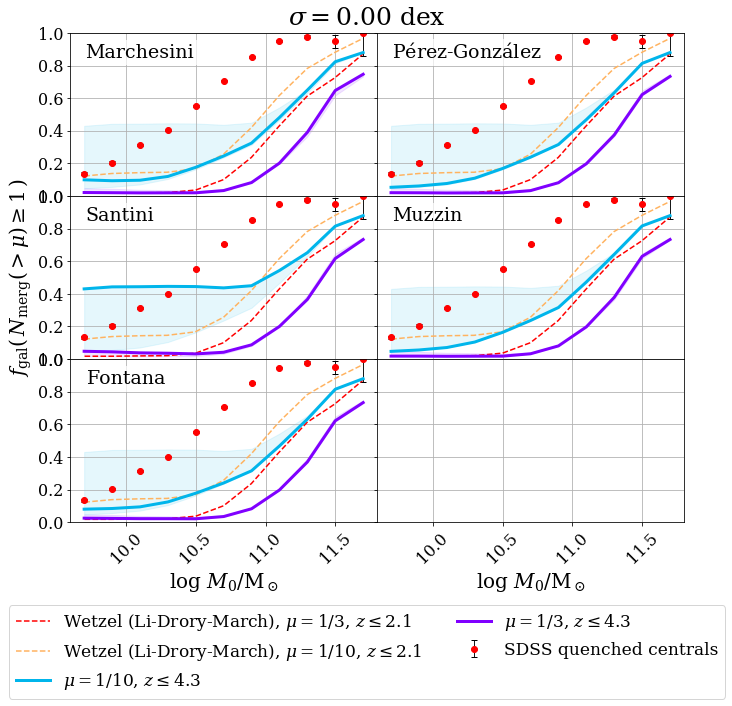

Uncollectable garbage: []
Number of unreachable objects collected by GC: 7909357
Uncollectable garbage: []


In [24]:
def mous_run():
    mmin=3.
    scat=0.

    mous_mar_tpm=merg_rates.GalTreepmClass(htpm,
                                           source=merg_rates.bld_smf_compo('mous-mar'),
                                           scat=scat,
                                           mmin=mmin)
    mous_per_tpm=merg_rates.GalTreepmClass(htpm,
                                           source=merg_rates.bld_smf_compo('mous-per'),
                                           scat=scat,
                                           mmin=mmin)
    mous_san_tpm=merg_rates.GalTreepmClass(htpm,
                                           source=merg_rates.bld_smf_compo('mous-san'),
                                           scat=scat,
                                           mmin=mmin)
    mous_muz_tpm=merg_rates.GalTreepmClass(htpm,
                                           source=merg_rates.bld_smf_compo('mous-muz'),
                                           scat=scat,
                                           mmin=mmin)
    mous_fon_tpm=merg_rates.GalTreepmClass(htpm,
                                           source=merg_rates.bld_smf_compo('mous-fon'),
                                           scat=scat,
                                           mmin=mmin)

    gtpms_scat=[mous_mar_tpm, mous_per_tpm,
                mous_san_tpm, mous_muz_tpm,
                mous_fon_tpm]
    for gtpm in gtpms_scat:
        st=time.time()
        htpm.mp_tree(gal_tpm=gtpm)
        htpm.merg_tree(gal_tpm=gtpm)
        print('{0:0.1f} min runtime'.format((time.time()-st)/60.))
  
    calc_fs_and_plot(gtpms_scat,
                     scat=scat, ziend=34,
                     cutoff=None, cutdir=None)

    return None

mous_run()
clean_mem()

# Making a scattered run

running SHAM


100% |########################################################################|


running SHAM


100% |########################################################################|


running SHAM


100% |########################################################################|


running SHAM


100% |########################################################################|


running SHAM


100% |########################################################################|


building main progenitor tree:


100% |########################################################################|


building merger tree


1.7 min runtime
building main progenitor tree:


100% |########################################################################|


building merger tree


1.7 min runtime
building main progenitor tree:


100% |########################################################################|


building merger tree


1.7 min runtime
building main progenitor tree:


100% |########################################################################|


building merger tree


1.9 min runtime
building main progenitor tree:


100% |########################################################################|


building merger tree
1.9 min runtime
running quench data
running quench data
0.5 min runtime
running quench data
running quench data
0.8 min runtime
running quench data
running quench data
0.6 min runtime
running quench data
running quench data
0.6 min runtime
running quench data
running quench data
0.6 min runtime


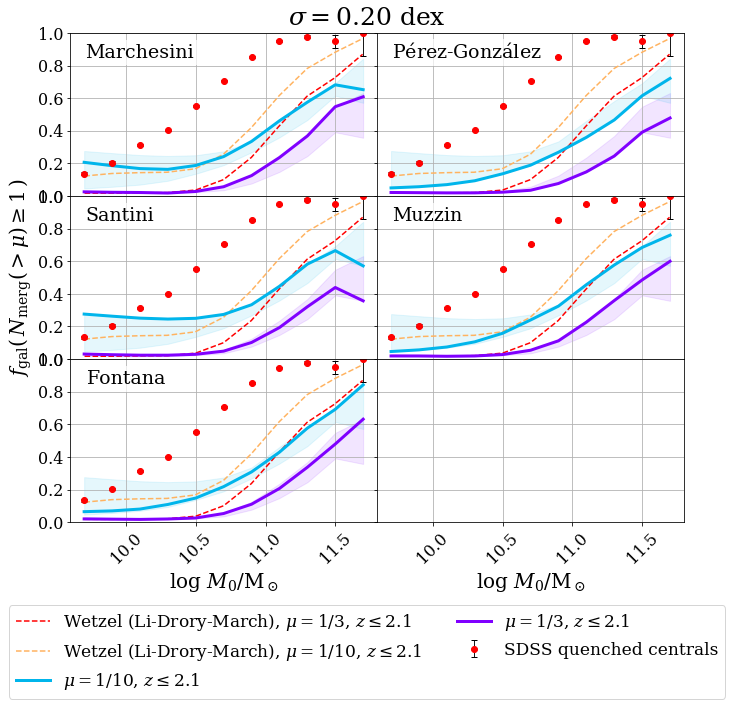

running quench data
running quench data
0.5 min runtime
running quench data
running quench data
0.7 min runtime
running quench data
running quench data
0.6 min runtime
running quench data
running quench data
0.5 min runtime
running quench data
running quench data
0.5 min runtime


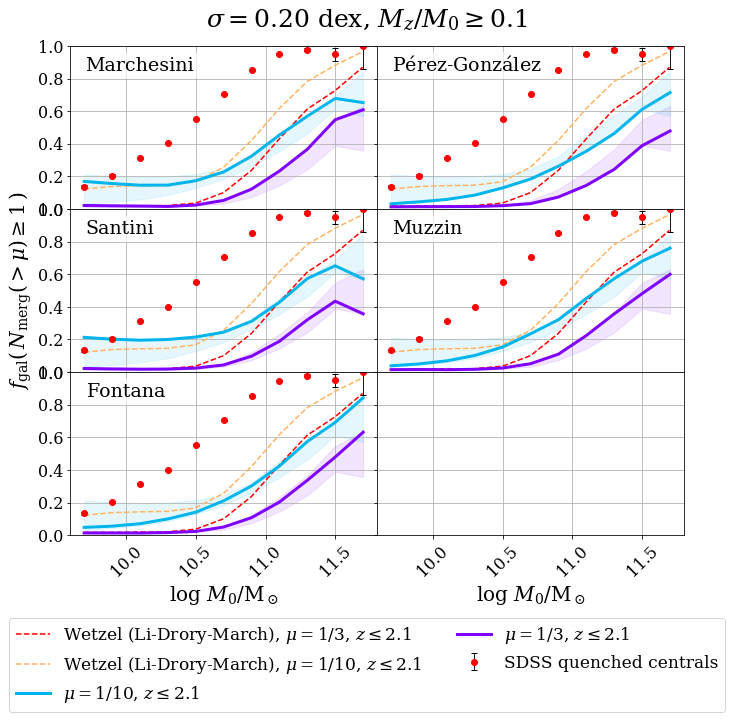

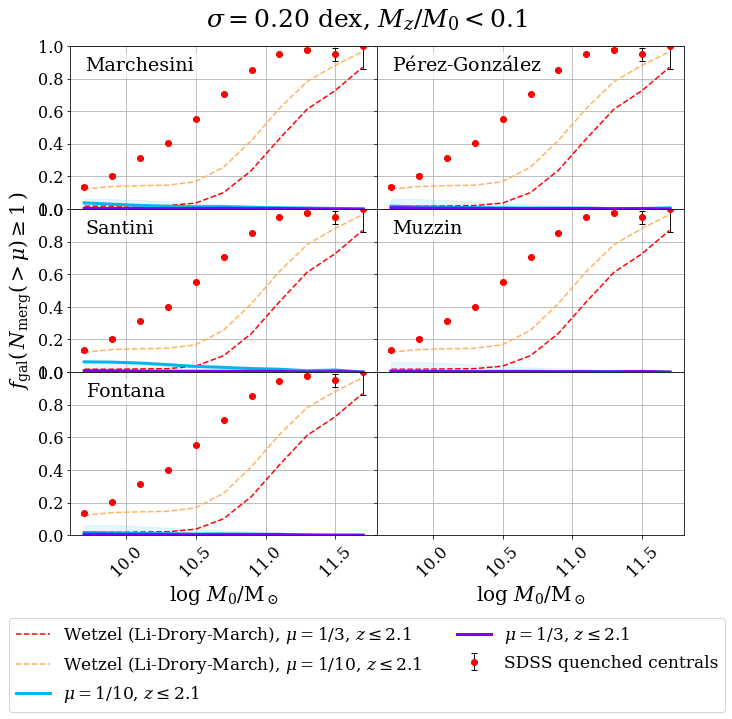

running quench data
running quench data
0.7 min runtime
running quench data
running quench data
1.1 min runtime
running quench data
running quench data
0.9 min runtime
running quench data
running quench data
0.8 min runtime
running quench data
running quench data
0.9 min runtime


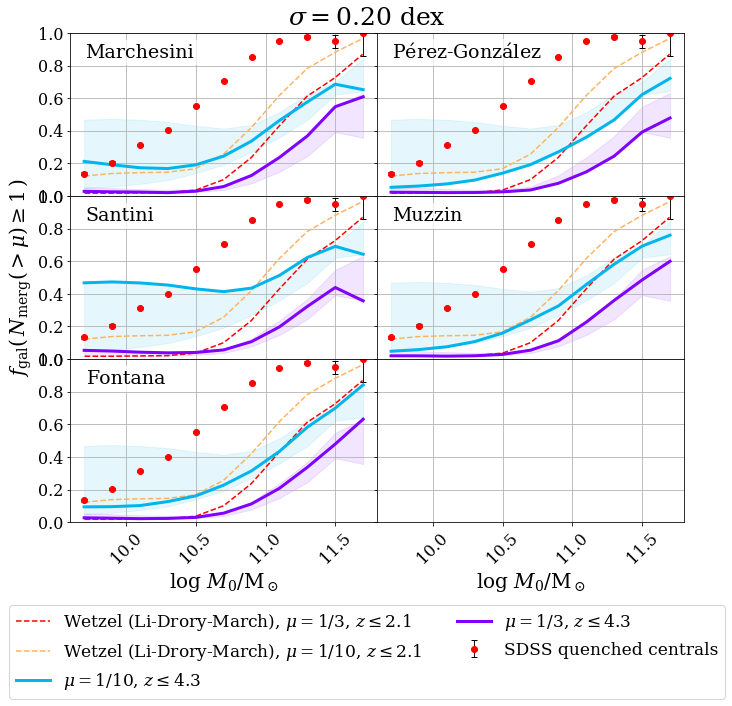

running quench data
running quench data
0.7 min runtime
running quench data
running quench data
0.7 min runtime
running quench data
running quench data
0.7 min runtime
running quench data
running quench data
0.6 min runtime
running quench data
running quench data
0.6 min runtime


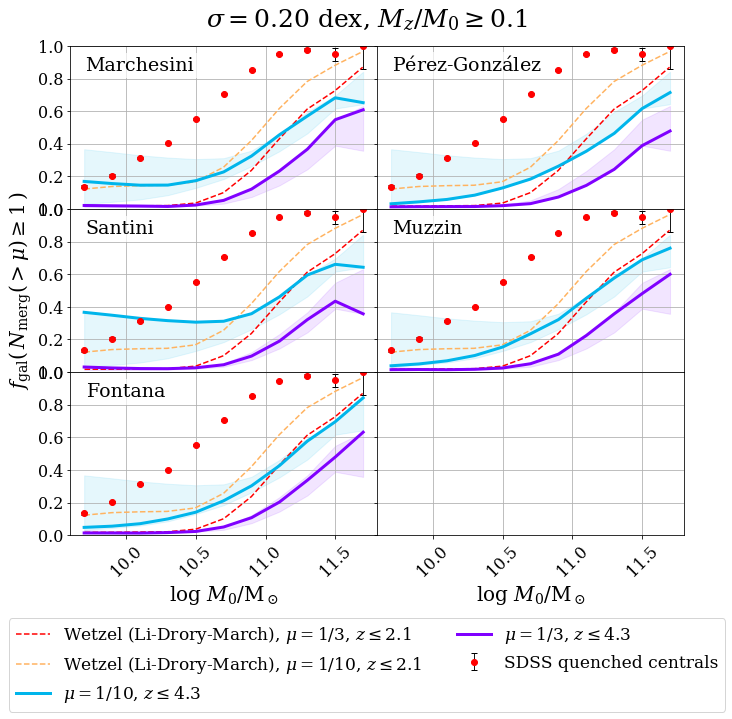

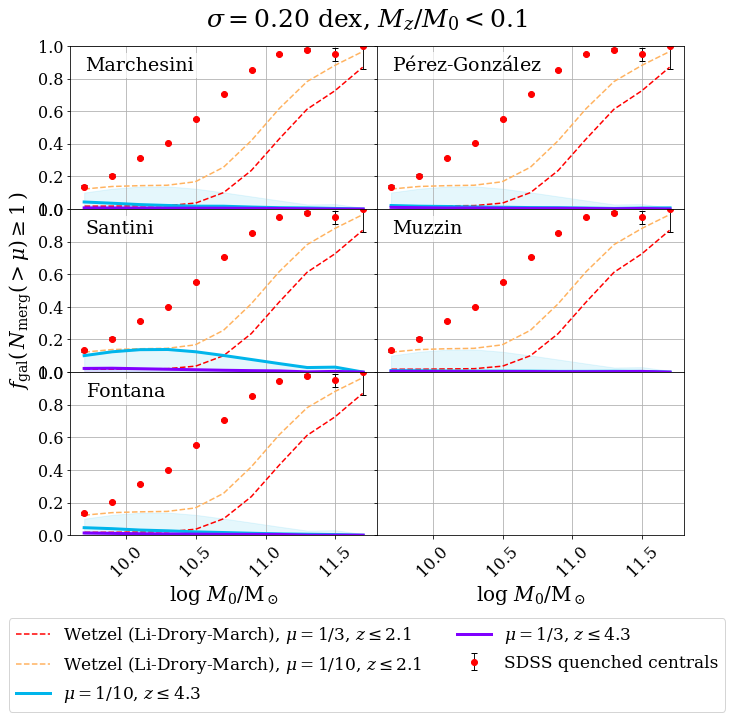

Uncollectable garbage: []
Number of unreachable objects collected by GC: 9810492
Uncollectable garbage: []


In [32]:
def scat_run():
    mmin=3.5
    scat=0.2
    
    mar_tpm_scat=merg_rates.GalTreepmClass(htpm,
            source=merg_rates.bld_smf_compo('marchesini'),scat=scat,
            mmin=mmin)
    per_tpm_scat=merg_rates.GalTreepmClass(htpm,
            source=merg_rates.bld_smf_compo('perez'),scat=scat,
            mmin=mmin)
    san_tpm_scat=merg_rates.GalTreepmClass(htpm,
            source=merg_rates.bld_smf_compo('santini'),scat=scat,
            mmin=mmin)
    muz_tpm_scat=merg_rates.GalTreepmClass(htpm,
            source=merg_rates.bld_smf_compo('muzzin-sameslope'),scat=scat,
            mmin=mmin)
    fon_tpm_scat=merg_rates.GalTreepmClass(htpm,
            source=merg_rates.bld_smf_compo('fontana'),scat=scat,
            mmin=mmin)
    
    tpms_scat=[mar_tpm_scat, per_tpm_scat, san_tpm_scat,
               muz_tpm_scat, fon_tpm_scat]
    for gtpm in tpms_scat:
        st=time.time()
        htpm.mp_tree(gal_tpm=gtpm)
        htpm.merg_tree(gal_tpm=gtpm)
        print('{0:0.1f} min runtime'.format((time.time()-st)/60.))

    def scat_comp(ziend):
        fss_nocut=calc_fs_and_plot(tpms_scat,
                                   scat=scat,
                                   ziend=ziend,
                                   cutoff=-np.inf,
                                   cutdir=None)
        fss_cut=calc_fs_and_plot(tpms_scat,
                                 scat=scat,
                                 ziend=ziend,
                                 cutoff=-1.,
                                 cutdir='\geq')
        for fs_nocut, fs_cut in zip(fss_nocut, fss_cut):
            assert np.array_equal(fs_nocut[0],fs_cut[0])
        fss_diff=[[fss_nocut[0][0],
                  np.array(fs_nocut[1])-np.array(fs_cut[1]),
                  np.array(fs_nocut[2])-np.array(fs_cut[2])] 
                  for fs_nocut, fs_cut 
                  in zip(fss_nocut, fss_cut)]
        mk_quench_plt(fss_diff[0], fss_diff[1], fss_diff[2],
                      fss_diff[3], fss_diff[4],
                      scat, zi=ziend, cutoff=-1., cutdir='<')           
        return None

    scat_comp(ziend=23)
    scat_comp(ziend=34)
    
scat_run()
clean_mem()

# Total runtime:

In [30]:
print('{0:0.1f} min total runtime'.format((time.time()-total_st)/60.))

224.3 min total runtime
